# Important Information on Interactivity

After installing the prerequisite packages, to enable the dynamical content in this Jupyter notebook, please configure your Jupyter client *in termonal* using 

```
jupyter nbextension enable --py --sys-prefix ipyleaflet
jupyter nbextension enable --py --sys-prefix widgetsnbextension
```

# Init

In [109]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import shapefile
import random
from ipywidgets import HTML

plt.style.use('default')

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

Palette = 'magma'
CycPalette = 'Greys'
DivPalette = 'RdYlGn'

FigSize = (20,12)
FigSizeMono = (20,6)
DPI = 72

# Distance on a sphere

def SphericalDistance(PtA,PtB):
    
    PtALat = PtA[0] * pi / 180
    PtALon = PtA[1] * pi / 180
    
    PtBLat = PtB[0] * pi / 180
    PtBLon = PtB[1] * pi / 180
                
    rTerra = 6371009 # metres
                 
    return 2*rTerra*np.arcsin(np.sqrt(np.sin((PtALat-PtBLat)/2)**2+np.cos(PtALat)*np.cos(PtBLat)*np.sin((PtALon-PtBLon)/2)**2))


# Map A User Location Onto Our Graph
def FindNearest(Points,Location):
    
    IPoints = np.array(Points) # Force to be n x 2 array
   
    Dist = (IPoints[:,0]-Location[0])**2 + (IPoints[:,1]-Location[1])**2
    
    Loc = np.where(Dist == np.min(Dist))[0] # In case there's a tie, pick the first one!

    return IPoints[Loc,:][0]

# Aux File IO
from json import dumps

def ShapeToJson(Shapefile):
    
        # read shape
    reader = shapefile.Reader(Shapefile)
    fields = reader.fields[1:]
    field_names = [field[0] for field in fields]
    buffer = []
    
    for sr in reader.shapeRecords():
       atr = dict(zip(field_names, sr.record))
       geom = sr.shape.__geo_interface__
       buffer.append(dict(type="Feature", geometry=geom, properties=atr)) 

    # write the GeoJSON

    geojson = open(f"{Shapefile}_converted.json", "w+")
    geojson.write(dumps({"type": "FeatureCollection","features": buffer}, indent=2) + "\n")
    geojson.close()

# Our Interactive Map

In [83]:
ShapeToJson('./Street/Final')

ShapeToJson('./CroppedRiver/0100')
ShapeToJson('./CroppedRiver/0250')
ShapeToJson('./CroppedRiver/0500')
ShapeToJson('./CroppedRiver/1000')
ShapeToJson('./CroppedRiver/1500')
ShapeToJson('./CroppedRiver/2000')

In [84]:
import json
with open('./Street/Final_converted.json', 'r') as f:
    StreetData = json.load(f)
 
Rivers = []
with open('./CroppedRiver/0100_converted.json', 'r') as f:
    R0100 = json.load(f)

with open('./CroppedRiver/0250_converted.json', 'r') as f:
    R0250 = json.load(f)
    
with open('./CroppedRiver/0500_converted.json', 'r') as f:
    R0500 = json.load(f)
    
with open('./CroppedRiver/1000_converted.json', 'r') as f:
    R1000 = json.load(f)
    
with open('./CroppedRiver/1500_converted.json', 'r') as f:
    R1500 = json.load(f)
    
with open('./CroppedRiver/2000_converted.json', 'r') as f:
    R2000 = json.load(f)
    

## Potential Refuge Points

In [119]:
ListInterest = [[-37.89761413273187, 176.7415237426758], 
                [-37.968831415745775, 176.7470169067383],
                [-38.02294285011436, 176.70478820800784],
                [-37.9750562620536, 176.85756683349612]] 

Icons = ['./Artworks/Hospital.png','./Artworks/CDef.png','./Artworks/Park.png','./Artworks/Ambulance.png']

Colors = plt.cm.YlOrRd_r(np.linspace(0,0.6,6))
CHex = []
for color in Colors:
    
    colorT = (int(color[0]*255),int(color[1]*255),int(color[2]*255))
    
    CHex.append('#%02x%02x%02x' % colorT)


In [125]:
import osgeo
import pyproj
import json
from ipyleaflet import Map, basemaps, basemap_to_tiles, Marker, CircleMarker, Popup, GeoJSON, Icon, MarkerCluster, Rectangle, LayerGroup

UserL = 2
MBoxL = 3     

center=(-37.941760730553966, 176.79370880126953)

m = Map(
    center=center,
    zoom=12,
    title = 'Group 11',
    basemap=basemaps.CartoDB.Positron
    )

    #crs = {'name': 'EPSG4326', 'custom': False}

m.layout.width = '1024px'
m.layout.height = '768px'
m.layout.arrange= 'center'

IntMark = []
for Location in ListInterest:
    
    icon = Icon(icon_url=random.choice(Icons), icon_size=[40, 40], icon_anchor=[20,20])
    mark = Marker(location=Location, icon=icon, draggable = False)
    IntMark.append(mark)
    

IntCluster = MarkerCluster(markers=tuple(IntMark))

m.add_layer(IntCluster)
    #marker = Marker(location=Location, draggable=False, icon = random.choice(Icons))


def handle_click(**kwargs):
    print(f"Hospital Location (Lat / Lon): {kwargs['coordinates']}")
marker.on_click(handle_click)


def handle_map_interaction(**kwargs):
   # markerU = CircleMarker(location=(0,0), draggable=True, visible = False)
   # m.add_layer(markerU)
    #m.add_layer(markerU)
    #print(kwargs)

    if kwargs['type'] == 'click':

        NLoc =  kwargs['coordinates']
        

        markerU = CircleMarker(location=NLoc, draggable=True, color = '#454545')

        m.add_layer(markerU)

            
        message = HTML()
        
        KeyLocation = FindNearest(ListInterest,NLoc)
        
        markerN = CircleMarker(location=KeyLocation.tolist(), draggable=True, color = '#ff0202',radius = 28 )
        
        m.add_layer(markerN)
        
        D = SphericalDistance(KeyLocation,NLoc)
        
        message.value = f'Risk index is .<br>Distance to Nearest Refuge Facility: {D:.5g}m<br>This is about {D/1.2/60:.0f} minutes on foot.'
        
        popup = Popup(
        location=NLoc,
        close_button=False,
        auto_close=False,
        child = message,
        close_on_escape_key=True
        )
        m.add_layer(popup)

        markerU.popup = message
     
m.on_interaction(handle_map_interaction)

S = GeoJSON(data = StreetData,
            style={'opacity': 1,
                   'fillOpacity': 1, 'weight': 1, 'color': 'black'})

m.add_layer(S)


S = GeoJSON(data = R0100,
            style={'opacity': 1,
                   'fillOpacity': 0.8, 'weight': 1, 'color': CHex[0]})

m.add_layer(S)

S = GeoJSON(data = R0250,
            style={'opacity': 1,
                   'fillOpacity': 0.6, 'weight': 1, 'color': CHex[1]})

m.add_layer(S)

S = GeoJSON(data = R0500,
            style={'opacity': 1,
                   'fillOpacity': 0.5, 'weight': 1, 'color': CHex[2]})

m.add_layer(S)

S = GeoJSON(data = R1000,
            style={'opacity': 1,
                   'fillOpacity': 0.45, 'weight': 1, 'color': CHex[3]})

S = GeoJSON(data = R1500,
            style={'opacity': 1,
                   'fillOpacity': 0.4, 'weight': 1, 'color': CHex[4]})

S = GeoJSON(data = R2000,
            style={'opacity': 1,
                   'fillOpacity': 0.4, 'weight': 1, 'color': CHex[5]})

m.add_layer(S)


m.add_layer(Rectangle(bounds=((figlim[0],figlim[1]), (figlim[2],figlim[3])), color="orange", fillOpacity = 0.0))


from ipyleaflet import Map, basemaps, WidgetControl
from ipywidgets import IntSlider, ColorPicker, jslink

zoom_slider = IntSlider(description='Zoom level:', min=11, max=15, value=12)
jslink((zoom_slider, 'value'), (m, 'zoom'))
widget_control1 = WidgetControl(widget=zoom_slider, position='topright')
m.add_control(widget_control1)




button = widgets.Button(
    description='Refresh',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)


def reset():
    m.clear_layers

button.on_click(reset)

widget_control2 = WidgetControl(widget=button, position='bottomright')
m.add_control(widget_control2)

m.save('my_map.html', title='My Map')
m

Map(center=[-37.941760730553966, 176.79370880126953], controls=(ZoomControl(options=['position', 'zoom_in_text…

# Risk Array

In [115]:
st = shapefile.Reader("./Street/Final")
tL = st.shapes()
figlim = st.bbox
Resol = 300
Hor = np.linspace(figlim[0],figlim[1],Resol)
Ver = np.linspace(figlim[2],figlim[3],Resol)

# QGIS-Powered Graph Theory

In [6]:
st = shapefile.Reader("./Street/Final")

tL = st.shapes()

len(st)
len(tL)

767

[176.399619776983, -38.37382588313738, 176.9848583550743, -37.800688588454086]


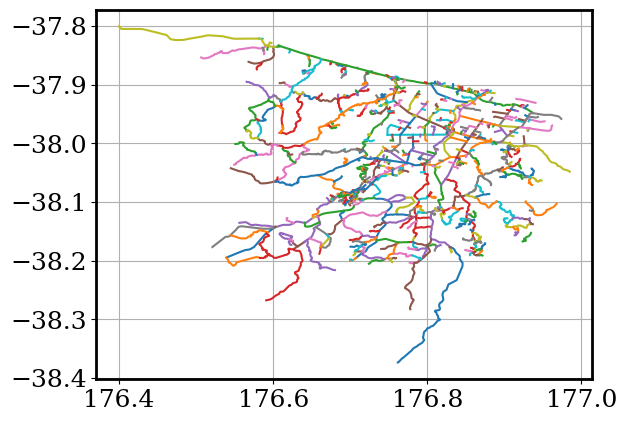

In [7]:
PointSet = []
figlim = st.bbox

print(figlim)

fig = plt.figure()
ax = fig.add_subplot(111)

#plt.xlim(figlim[0],figlim[1])
#plt.ylim(figlim[2],figlim[3])

#ax.set_aspect = 'equal'

ax.grid()

for i in range(len(st)):

    PointSet += tL[i].points
    
    PAR = np.array(tL[i].points)

    PAR = PAR.reshape([-1,2])

    ax.plot(PAR[:,0],PAR[:,1])

In [8]:
seen = set()
uniq = []

Intersections = PointSet.copy()

for x in PointSet:
    if x not in seen:
        uniq.append(x)
        seen.add(x)
        
for x in uniq:  
    Intersections.remove(x)

fig = plt.figure()
#ax = fig.add_subplot(111)

#plt.xlim(figlim[0],figlim[1])
#plt.ylim(figlim[2],figlim[3])

ax.set_aspect = 'equal'

ax.grid()


seenPoints = np.array(Intersections)
print('Done!')

Done!


<Figure size 640x480 with 0 Axes>

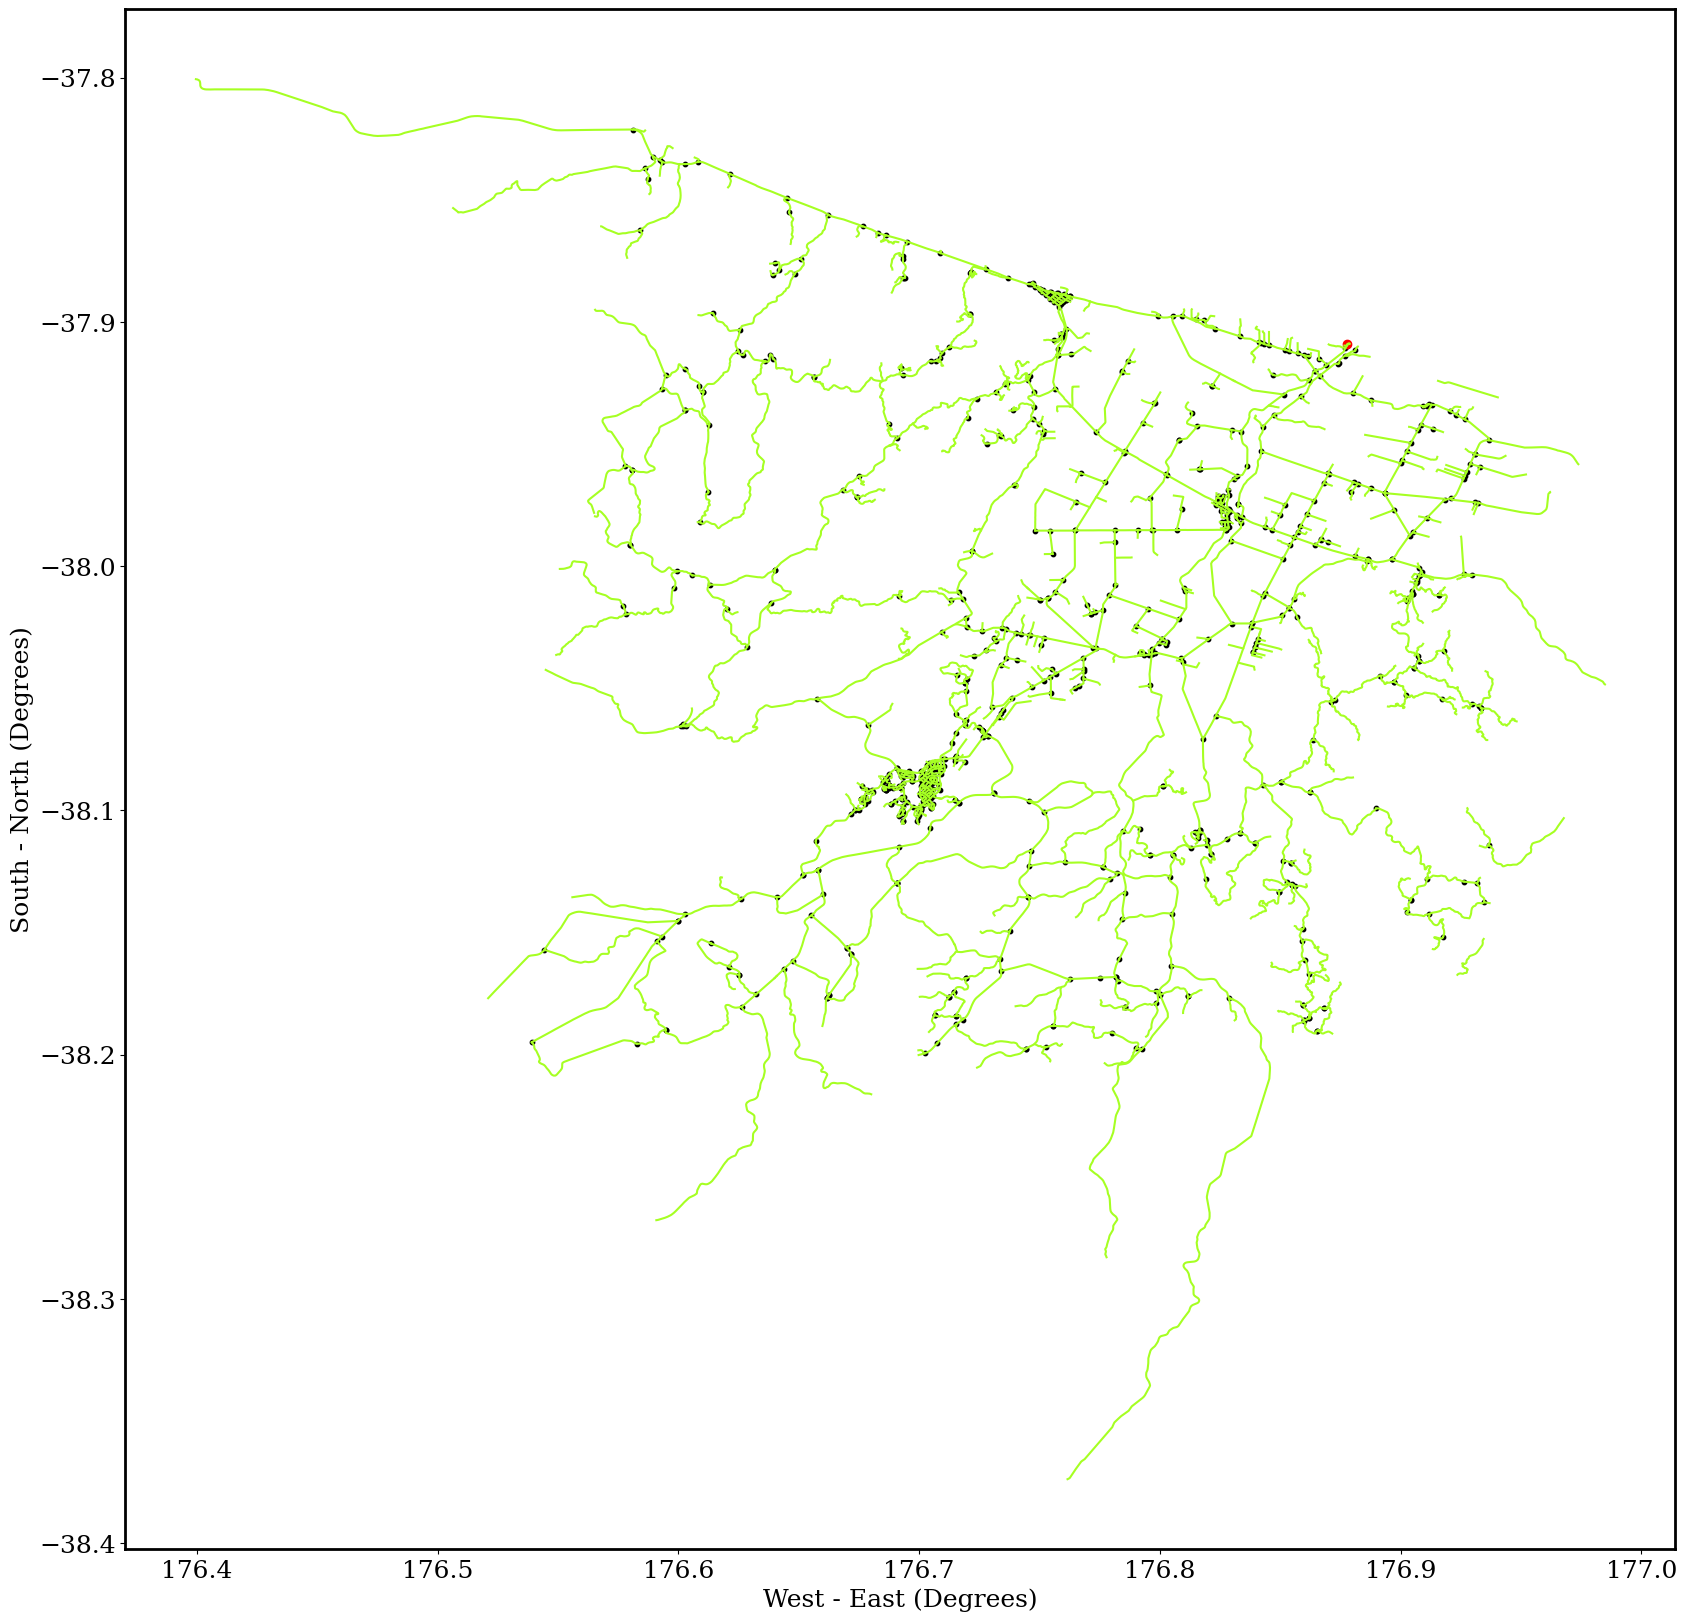

In [80]:
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(111)


plt.scatter(seenPoints[:,0],seenPoints[:,1],color = 'k', s = 10)

for i in range(len(st)):
    
    PAR = np.array(tL[i].points)

    PAR = PAR.reshape([-1,2])

    ax.plot(PAR[:,0],PAR[:,1], color = '#a6ff23')

ax.set_xlabel('West - East (Degrees)')

ax.set_ylabel('South - North (Degrees)')

InputX, InputY = 

Output = FindNearest(Intersections,[InputX,InputY])


plt.scatter([Output[0]],[Output[1]],color = 'r')

## Graph Theory Stuff

In [ ]:
StreetList = []
for i in range(len(st)):
    StreetList.append(tL[i].points)

In [ ]:
a = FindNearest(Intersections,[5.8e6,1.89e6])